In [11]:
import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 

import matplotlib.pyplot as plt
import numpy as np

from ctapipe.image.charge_extractors import LocalPeakIntegrator

from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr import TimeCalCorr, plot_corr_curve, make_hist

plt.rcParams['font.size'] = 20

In [16]:
input_file_1 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00167.0000.fits.fz"

config_inter = Config({
    "LocalPeakIntegrator": {
        "window_shift": 3,
        "window_width": 7 
    }
})
integrator = LocalPeakIntegrator(config=config_inter)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400,
        "tel_id": 0, # for EVB3 will be 
    }
})


In [ ]:
gain = 0
nr = 200
pix = 2

reader = LSTEventSource(input_url=input_file_1, max_events=20)
lst_r0 = LSTR0Corrections(config=config_corr)
t = np.linspace(2, 37, 36)

for ev in reader:
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    pixel = expected_pixel_id[nr * 7 + pix]                                                                                      
    lst_r0.subtract_pedestal(ev)
    lst_r0.time_lapse_corr2(ev)
    lst_r0.interpolate_spikes(ev)
    
    integration, peakpos, window = integrator.extract_charge(ev.r1.tel[0].waveform[:, :, :])
    plt.figure(figsize=(12, 7))
    plt.step(t,  ev.r0.tel[0].waveform[gain, pixel, 2:38], color="blue", label="raw waveform")
    corr_waveform = (ev.r1.tel[0].waveform[gain, pixel, 2:38]-lst_r0.offset)
    plt.step(t,  corr_waveform, color="red", label="corr waveform")
    plt.plot(peakpos[gain, [pixel]], ev.r1.tel[0].waveform[gain, pixel, peakpos[gain, pixel]]-400, 'ro')
    plt.plot([0, 40], [0, 0])
    plt.ylim([-50, 1300])   
    plt.show()
    print(integration[gain, pixel])

In [35]:
gain = 0
nr = 155
pix = 3

n_combine = 8
n_harm = 8
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)

reader = LSTEventSource(input_url=input_file_1, max_events=3000)
lst_r0 = LSTR0Corrections(config=config_corr)

for i, ev in enumerate(reader):
    if i%200 == 0:
        print(i)
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    pixel = expected_pixel_id[nr * 7 + pix]                                                                                      
    lst_r0.subtract_pedestal(ev)
    lst_r0.time_lapse_corr2(ev)
    lst_r0.interpolate_spikes(ev)
    
    fc = get_first_capacitor(ev, nr)
    integration, peakpos, window = integrator.extract_charge(ev.r1.tel[0].waveform[:, :, :])
    if integration[gain, pixel] > 4000:
        pos = peakpos[gain, pix]
        timeCorr.fill(fc[gain, pix]%1024, pos)

timeCorr.finalize()

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800


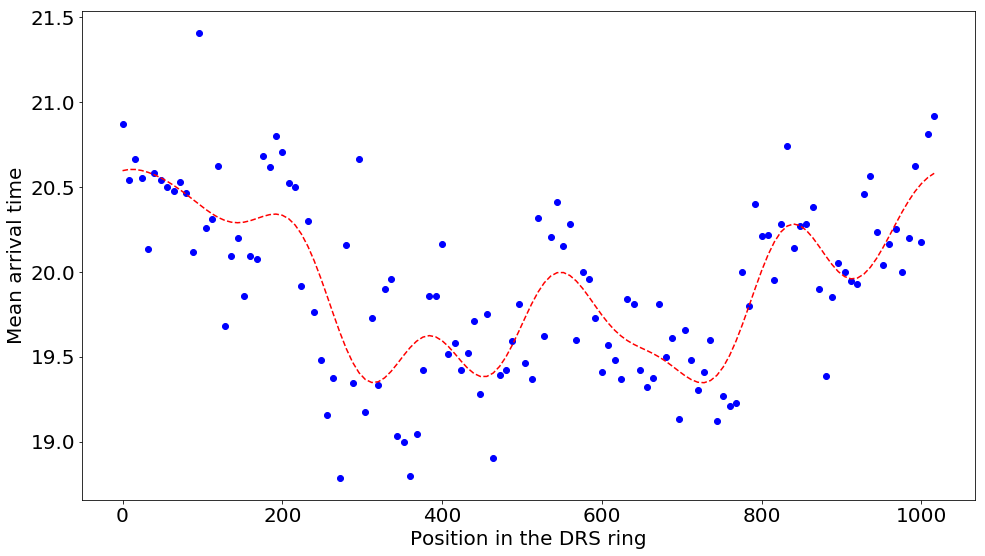

In [36]:
an = timeCorr.fan
bn = timeCorr.fbn
fMeanVal = timeCorr.fMeanVal
plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)

In [37]:
input_file_2 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00167.0001.fits.fz"
reader = LSTEventSource(input_url=input_file_2, max_events=2000)
lst_r0 = LSTR0Corrections(config=config_corr)

arrival_time_list = [] 
arrival_time_corr_list = []

for i, ev in enumerate(reader):
    if i%200 == 0:
        print(i)
    expected_pixel_id = ev.lst.tel[0].svc.pixel_ids
    pixel = expected_pixel_id[nr * 7 + pix]                                                                                      
    lst_r0.subtract_pedestal(ev)
    lst_r0.time_lapse_corr2(ev)
    lst_r0.interpolate_spikes(ev)
    
    fc = get_first_capacitor(ev, nr)
    integration, peakpos, window = integrator.extract_charge(ev.r1.tel[0].waveform[:, :, :])
    if integration[gain, pixel] > 4000:
        pos = peakpos[gain, pix]
        arrival_time_list.append(pos)
        arrival_time_corr_list.append(timeCorr.get_corr_time(fc[gain, pix]%1024))


0
200
400
600
800
1000
1200
1400
1600
1800


1.175486176013993
0.3992366984306316


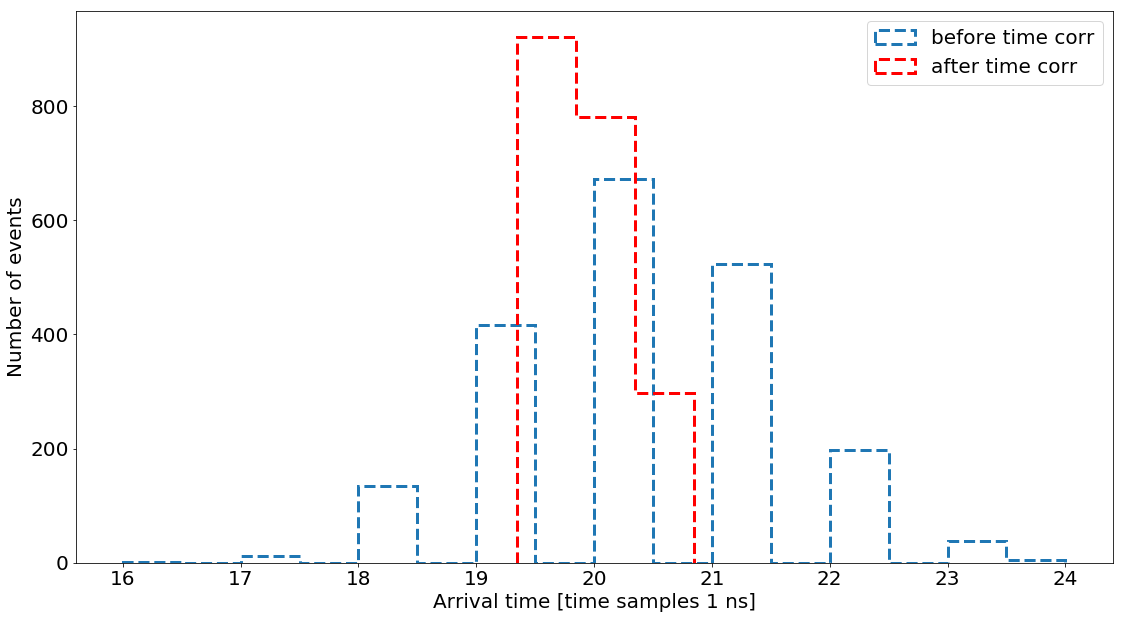

In [41]:
make_hist(arrival_time_list, arrival_time_corr_list, binwidth = 0.5)
print(np.std(arrival_time_list))
print(np.std(arrival_time_corr_list))